In [135]:
%display latex
from utils import *

The modified update rule does not use a negative for the other indices.
$$
  x_i = 
  \begin{cases}
    \frac{1}{x_i}, & \text{ if } i = \ell, \\
    \frac{x_i}{x_\ell}, & \text{ otherwise.} \\
  \end{cases}
$$

# Brute-Force Search

The brute-force search is done in a breadth-first fashion.
We try every list of length $n$ and then every list of length $n + 1$,
until we find a period in the representation.

In [136]:
def brute_force(xs, max_depth, exhaustive=False):
    indices = [0]
    result = None
    d = len(xs)
    while indices:
        init, repeat = get_period(xs, indices[1:])
        if repeat:
            if not exhaustive:
                return init, repeat
            if not result:
                result = []
            result.append((init, repeat))
        indices = increment_nary(indices, d, max_depth + 1)
    return result

def brute_force_2d(xs, max_depth, exhaustive=False):
    def get_indices_list(indices_value):
        result = []
        while indices_value > 0:
            if indices_value & 1 != 0:
                result.append(1)
            else:
                result.append(0)
            indices_value >>= 1
        return result[:-1]
        
    indices = 0
    result = None
    d = len(xs)
    while indices < (2 << max_depth):
        init, repeat = get_period(xs, get_indices_list(indices))
        if repeat:
            if not exhaustive:
                return init, repeat
            if not result:
                result = []
            result.append((init, repeat))
        indices += 1
    return result

Here is, for example, the period for $\sqrt[3]{4}$. Notably, this value likely doesn't have a periodic representation in the Jacobi-Perron algorithm. First, the pivots which lead to a period are shown. The period is marked with a line over the pivots. The actual representation of $\sqrt[3]{4}$ is shown in the next block.

In [137]:
d = 2
p = x^3 - 7
K.<alpha> = NumberField(p, embedding=RR(1))

xs = (alpha, alpha^2)
init, repeat = brute_force_2d(xs, 15)
pretty_print(pretty_continued_fraction(init, repeat))
pretty_print(list(get_coeffs(xs, *init, *repeat)))
pretty_print(RR(get_decrease(xs, *init, *repeat)))

[0, \overline{1, 0, 0, 1, 0, 0, 0}]

[(1, 3), (1, 0), (0, 1), (7, 2), (1, 1), (1, 1), (3, 2), (1, 0)]

0.000660066869158871

In [4]:
periodic_pivot_table(xs, init, repeat)

TypeError: tuple indices must be integers or slices, not list

In [179]:
ys = xs
rows = []
for i in init + repeat:
    def f(zs):
        return frac(prod([z**d for z in zs]))
    choices = [pivot(ys, l)[0] for l in range(d)]
    row = [zs for l, zs in enumerate(choices)]
    rows.append([i, *ys] + real_list(flatten(row)) + flatten(row))
    ys, _ = pivot(ys, i)

table(rows)

\(0\),\(\alpha\),\(\alpha^{2} - \alpha\),\(3.8473\),\(1.2599\),\(0.7937\),\(3.0536\),\(\alpha^{2} + \alpha + 1\),\(\alpha\),\(\frac{1}{2} \alpha^{2}\),\(\frac{1}{2} \alpha^{2} + \alpha + 1\)
\(1\),\(\alpha^{2} + \alpha + 1\),\(\alpha\),\(1.1802\),\(0.3068\),\(3.2599\),\(3.8473\),\(\frac{3}{10} \alpha^{2} + \frac{2}{5} \alpha + \frac{1}{5}\),\(\frac{1}{10} \alpha^{2} - \frac{1}{5} \alpha + \frac{2}{5}\),\(\alpha + 2\),\(\alpha^{2} + \alpha + 1\)
\(0\),\(\alpha + 2\),\(\alpha^{2} + \alpha + 1\),\(3.8473\),\(3.2599\),\(0.3068\),\(1.1802\),\(\alpha^{2} + \alpha + 1\),\(\alpha + 2\),\(\frac{1}{10} \alpha^{2} - \frac{1}{5} \alpha + \frac{2}{5}\),\(\frac{3}{10} \alpha^{2} + \frac{2}{5} \alpha + \frac{1}{5}\)
\(1\),\(\alpha^{2} + \alpha + 1\),\(\alpha + 2\),\(1.1802\),\(0.3068\),\(3.2599\),\(3.8473\),\(\frac{3}{10} \alpha^{2} + \frac{2}{5} \alpha + \frac{1}{5}\),\(\frac{1}{10} \alpha^{2} - \frac{1}{5} \alpha + \frac{2}{5}\),\(\alpha + 2\),\(\alpha^{2} + \alpha + 1\)


Period lengths for the first 28 numbers:

In [260]:
for i in range(2, 20):
    try:
        K.<alpha> = NumberField(x^(d+1) - i, embedding=RR(1))
        xs = tuple(sum(alpha^j for j in range(1, i + 1)) for i in range(1, d + 1))
        init, repeat = brute_force(xs, 20)[0]
        print(i, len(repeat))
    except KeyboardInterrupt:
        break
    except:
        pass

2 2
3 2
4 8
5 6
6 8
7 6
9 2
10 4
11 6
12 10
13 6
14 4
15 6
16 14
17 8
18 6
19 6


# Geometric Interpretation of the Continued Fractions

[2; 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, ...]

[1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1]

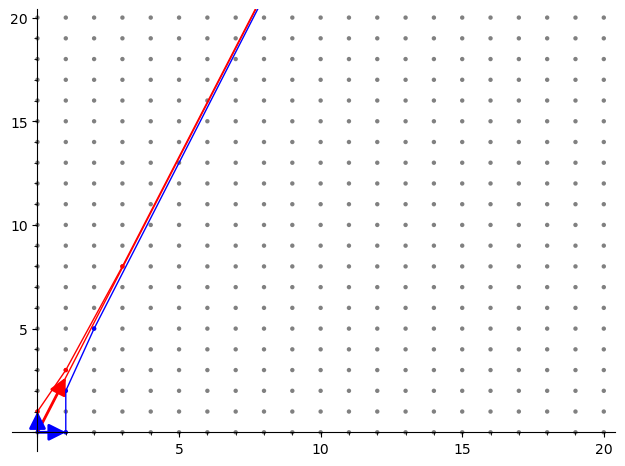

In [15]:
plot_size = 20

alpha = sqrt(7)
cf = continued_fraction(alpha)
terms = [cf[:i+1].value() for i in range(40)]
points = [(term.denominator(), term.numerator()) for term in terms]

basis = [(0, 1), (1, 0)]
points_even = [basis[1]] + points[0::2]
points_odd = [basis[0]] + points[1::2]
diff = basis + [(a[0] - b[0], a[1] - b[1]) for a, b in zip(points, points[1:])]

lattice = point([(x, y) for x in range(plot_size + 1) for y in range(plot_size + 1)], color='gray')
scene = [
    lattice,
    arrow((0, 0), (1, alpha), color='red'),
    plot(alpha * x, (x, 0, 10), color='red'),
    sum(arrow((0, 0), b, color='blue') for b in basis),
    point(points_odd, color='red'),
    line(points_odd, color='red'),
    point(points_even, color='blue'),
    line(points_even, color='blue'),
]

pretty_print(cf)
pretty_print([abs(det(matrix([odd, even]))) for even, odd in zip(diff[:], diff[1:])])
show(sum(scene), xmin=-0.5, xmax=plot_size, ymin=-0.5, ymax=plot_size)

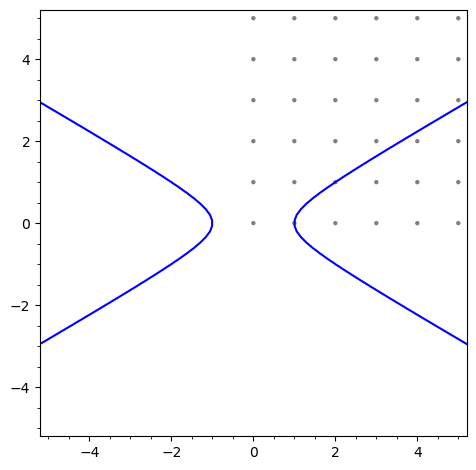

In [36]:
x, y = var('x, y')

show(lattice + implicit_plot(x^2 - 3 * y^2 == 1, (x, -10, 10), (y, -10, 10)),
     xmin=-5, ymin=-5, xmax=5, ymax=5)

# Equal Distance between Neighbors

The first polynomial is the "neighbor" polynomial, which is derived from the following equation:
$$
  x_1 = \frac{x_2}{x_1} - 1 = \dots = \frac{x_d}{x_{d-1}} - 1 = \frac{1}{x_d} - 1.
$$
This results in the equation
$$
  x_d^{d+1} + x_d - 1 = 0, \quad x_i = x_d^{d + 1 - i}
$$

In [80]:
def neighbor_distance(xs):
    dist = []
    for x, y in zip([*xs, 1], [1, *xs]):
        if y == 0 or x == 0:
            dist.append(1)
        else:
            dist.append(frac(x / y))
    return dist

def distance_matrix(xs):
    D = [[0 for _ in xs] for _ in xs]
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            if x == 0 or y == 0:
                D[i][j] = 1
            elif i == j:
                D[i][j] = frac(1 / x)
            else:
                D[i][j] = frac(x / y)
    return D

def real_distance_matrix(xs):
    dist = distance_matrix(xs)
    return [[RR(d) for d in row] for row in dist]

# Indices are zero-based. An index of -1 indicates selecting nothing in the first iteration and selecting 0 in the next iteration.
# Similarly, d - 1 indicates selecting d - 1 in the first iteration and nothing in the next iteration.
def select(xs):
    min_index = None
    min_dist = 1
    for i, dist in enumerate(neighbor_distance(xs)):
        if min_dist > dist:
            min_dist = dist
            min_index = i - 1
    return min_index

In [160]:
def neighbor_poly(d):
    return x ** (d+1) + x - 1
neighbor_poly(5)

x^6 + x - 1

The polynomial gives us the field $\mathbb{Q}/ (x^{d+1} + x - 1)$.

In [195]:
d = 3
p = neighbor_poly(d)
K.<psi> = NumberField(p, embedding=RR(0.5))
K

Number Field in psi with defining polynomial x^4 + x - 1 with psi = 0.7244919590005156?

For our input, we choose $x_i = \psi^{d+1-i}$.

In [196]:
xs = tuple(sorted([psi^(d+1-i) for i in range(1,d+1)]))

table([(i, x,RR(x)) for i, x in enumerate(xs)], header_row=[r'$i$', r'$x_i$'])

$i$   $x_i$
├─────┼───────┤
  0     psi^3
  1     psi^2
  2     psi

The distance between neighbors is indeed the same.

In [197]:
dist = neighbor_distance(xs)

table([dist, [round(RR(d), 3) for d in dist]])

\(\psi^{3}\),\(\psi^{3}\),\(\psi^{3}\),\(\psi^{3}\)
\(0.38\),\(0.38\),\(0.38\),\(0.38\)


Therefore, we can expect a decrease of at least $\psi^3$ over two iterations. However, this condition does not hold up after those two iterations when choosing any element to pivot with. It only holds up if we choose the maximum $x_d$ of those elements. Choosing any other pivot, destroys this solution.

In [199]:
n = 50
d = len(xs)

ys = xs
rows = [[
    *[f'$x_{i+1}$' for i in range(d)], 
    *[fr'$\{{x_{{{i+2}}}/x_{{{i+1}}}\}}$' for i in range(-1, d)], 
    r'$\ell_1$', 
    r'$\ell_2$',
]]

for i in range(n):
    # select pivot
    l = select(ys)
    
    # Add row to the output
    dist   = [round(RR(d), 3) for d in neighbor_distance(ys)]
    values = [round(RR(y), 3) for y in ys]
    rows.append([*values, *dist, '-' if l == -1 else l, '-' if l == d - 1 else l + 1])

    # pivot
    if l == -1:
        ys, _ = pivot(ys, 0)
    elif l == d - 1:
        ys, _ = pivot(ys, d - 1)
    else:
        ys, _ = pivot(ys, l, l + 1)
    
table(rows, header_row=True, align='center')

\(x_1\),\(x_2\),\(x_3\),\(\{x_{1}/x_{0}\}\),\(\{x_{2}/x_{1}\}\),\(\{x_{3}/x_{2}\}\),\(\{x_{4}/x_{3}\}\),\(\ell_1\),\(\ell_2\)
\(0.38\),\(0.525\),\(0.724\),\(0.38\),\(0.38\),\(0.38\),\(0.38\),-,\(0\)
\(2.63\),\(1.38\),\(1.905\),\(0.63\),\(0.525\),\(0.38\),\(0.525\),\(1\),\(2\)
\(1.724\),\(1.656\),\(2.63\),\(0.724\),\(0.96\),\(0.588\),\(0.38\),\(2\),-
\(1.151\),\(1.041\),\(1.588\),\(0.151\),\(0.905\),\(0.525\),\(0.63\),-,\(0\)
\(6.64\),\(0.276\),\(3.905\),\(0.64\),\(0.041\),\(0.174\),\(0.256\),\(0\),\(1\)
\(1.308\),\(2.322\),\(0.964\),\(0.308\),\(0.775\),\(0.415\),\(0.037\),\(2\),-
\(0.32\),\(0.334\),\(1.037\),\(0.32\),\(0.043\),\(0.11\),\(0.964\),\(0\),\(1\)
\(2.956\),\(23.073\),\(2.7\),\(0.956\),\(0.805\),\(0.117\),\(0.37\),\(1\),\(2\)
\(0.26\),\(1.199\),\(1.56\),\(0.26\),\(0.606\),\(0.3\),\(0.641\),-,\(0\)
\(3.84\),\(0.766\),\(2.15\),\(0.84\),\(0.199\),\(0.808\),\(0.465\),\(0\),\(1\)


## Other polynomials

$$
    x^{d+1} + \sum_{k=1}^d k x^{d-k} = 1
$$

In [9]:
xs = (1, 4^(1/3), 16^(1/3))
indices = [1, 2] + [2]*20
table([[RR(x) for x in pivot(xs, *indices[:i+1])] for i in range(len(indices))])

TypeError: unable to convert '(1/4*4^(2/3),1/4*4^(2/3),1/2*4^(2/3)*2^(1/3)-1)' to a real number

# $d$-bonacci Numbers


In [145]:
def nbonacci_poly(d):
    i = var('i')
    return x^(d+1) + sum(x^i, i, 1, d) - 1
nbonacci_poly(3), *[r[0] for r in nbonacci_poly(1).roots()]

(x^4 + x^3 + x^2 + x - 1, -1/2*sqrt(5) - 1/2, 1/2*sqrt(5) - 1/2)

In [242]:
y = polygen(RR, 'y')
d = 5

p = nbonacci_poly(d)
psi_real = find_root(p, 0, 1)
K.<psi> = NumberField(p, embedding=RR(psi_real))

In [168]:
xs = tuple(sum(psi^i for i in range(1, k+1)) for k in range(1, d + 1))
xs

(psi,
 psi^2 + psi,
 psi^3 + psi^2 + psi,
 psi^4 + psi^3 + psi^2 + psi,
 psi^5 + psi^4 + psi^3 + psi^2 + psi)

In [216]:
ys = pivot(xs, 0)
argmin(ys), ys

(1,
 (psi^5 + psi^4 + psi^3 + psi^2 + psi,
  psi,
  psi^2 + psi,
  psi^3 + psi^2 + psi,
  psi^4 + psi^3 + psi^2 + psi))

In [254]:
q = factor(-x^6 * p(x=1/x))
phi_real = find_root(q, 1, 2)
L.<phi> = NumberField(q, embedding=RR(phi_real))
q.list()

[-1, -1, -1, -1, -1, -1, 1]

# Worst-Case Analysis

In [60]:
d = 3
xs = tuple(i / (d + 1) for i in range(1, d + 1))
pivot(xs, 0)

(0, 0, 0)

In [133]:
def unpivot(y, values, indices):
    for a, l in zip(values, indices):
        x = [0] * len(ys)
        for i, (yi, ai) in enumerate(zip(y, a)):
            if i == l:
                x[i] = frac(1 / (ai + yi))
            else:
                x[i] = frac((ai + yi) / (a[l] + y[l]))
        y = x
    return y

In [165]:
ys = tuple(sorted(unpivot(xs, [(2, 1, 1)] * 5, [0] * 5)))
table(distance_matrix(ys), header_row=ys, header_column=['', *ys])

,\(\frac{128}{309}\),\(\frac{218}{309}\),\(\frac{73}{103}\)
\(\frac{128}{309}\),\(\frac{53}{128}\),\(\frac{64}{109}\),\(\frac{128}{219}\)
\(\frac{218}{309}\),\(\frac{45}{64}\),\(\frac{91}{218}\),\(\frac{218}{219}\)
\(\frac{73}{103}\),\(\frac{91}{128}\),\(\frac{1}{218}\),\(\frac{30}{73}\)


In [163]:
pivot(ys, 0, 1, 2)

(0, 0, 0)

In [16]:
K.<phi> = NumberField(x^3 - x - 1, embedding=RR(2))
psi = 1/phi

A = matrix([[1, phi, phi^2], [1, -psi]]).transpose()
b = vector([1, 1])
xs = A.solve_right(b)
pivot(xs, 1, 1, *[1]*10)

(0, phi - 1)

In [77]:
def min_pivot(xs, n):
    coeffs = []
    for _ in range(n):
        l = None
        for i, xi in enumerate(xs):
            if (l is None or frac(xs[l]) > frac(xi)) and frac(xi) != 0:
                l = i
        if l is None:
            break
            
        xs, c = pivot(xs, l)
        coeffs += c
    return xs, coeffs